In [1]:
import os
import pickle
import numpy as np
import random 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

from multiprocessing import Pool, TimeoutError

from tokenizers import BertWordPieceTokenizer

import jellyfish

plt.rcParams['figure.dpi'] = 120

In [3]:
full_ocr_path = os.path.join('..', 'data', 'post-ocr-correction', 'pickles', 'combined_ocr.pickle')
full_gs_path = os.path.join('..', 'data', 'post-ocr-correction', 'pickles', 'combined_gs.pickle')
data_path = os.path.join('..', 'data', 'post-ocr-correction', 'full')

if not os.path.exists(full_ocr_path) or not os.path.exists(full_gs_path):
    raise Exception('data not found')
else:
    with open(full_ocr_path, 'rb') as ocr_handle:
        ocr_file_data = pickle.load(ocr_handle)
    
    with open(full_gs_path, 'rb') as gs_handle:
        gs_file_data = pickle.load(gs_handle)

In [3]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def plot_list_histogram(lst, title: str):
    labels, values = zip(*Counter(lst).items())
    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.title(title)

    plt.show()
    
def print_statistics(lst, title:str):
    max_value = np.max(lst)
    min_value = np.min(lst)
    avg_value = np.mean(lst)
    
    print(f'{title}:\nMAX: {max_value}\nMIN: {min_value}\nAVG: {avg_value}')


In [5]:
ocr_lengths = np.array([len(x) for x in ocr_file_data])
gs_lengths = np.array([len(x) for x in gs_file_data])

# indices = np.argsort(ocr_lengths)
# print(indices)


# print(ocr_file_data[0])
# ocr_file_data_np = np.array(ocr_file_data, dtype=object)
# gs_file_data_np = np.array(gs_file_data)[indices]


# plot_list_histogram(ocr_lengths, 'OCR')
# print_statistics(ocr_lengths, 'OCR')

# plot_list_histogram(gs_lengths, 'GS')
# print_statistics(gs_lengths, 'GS')

In [6]:
full_ocr_tokens_path = os.path.join('..', 'data', 'post-ocr-correction', 'pickles', 'combined_ocr_tokens.pickle')
full_gs_tokens_path = os.path.join('..', 'data', 'post-ocr-correction', 'pickles', 'combined_gs_tokens.pickle')

vocab_path = os.path.join('..', 'data', 'vocabularies', 'bert-base-cased-vocab.txt')
tokenizer = BertWordPieceTokenizer(vocab_path, lowercase=False)

if not os.path.exists(full_ocr_tokens_path) or not os.path.exists(full_gs_tokens_path):        
    raise Exception('Data not found')
else:
    with open(full_ocr_tokens_path, 'rb') as ocr_handle:
        ocr_tokens = pickle.load(ocr_handle)
    
    with open(full_gs_tokens_path, 'rb') as gs_handle:
        gs_tokens = pickle.load(gs_handle)

In [8]:
ocr_tokens_lengths = np.array([len(x) for x in ocr_tokens])
gs_tokens_lengths = np.array([len(x) for x in gs_tokens])

# indices = np.argsort(ocr_tokens_lengths)

# ocr_tokens_lengths = np.array(ocr_tokens_lengths)[indices]
# gs_tokens_lengths = np.array(gs_tokens_lengths)[indices]
# ocr_tokens = np.array(ocr_tokens)[indices]
# gs_tokens = np.array(gs_tokens)[indices]

# print(f'OCR - Less than 2000 length: {len(ocr_tokens_lengths[ocr_tokens_lengths <= 2000]) / len(ocr_tokens_lengths) * 100}')
# print(f'GS  - Less than 2000 length: {len(gs_tokens_lengths[gs_tokens_lengths <= 2000]) / len(gs_tokens_lengths) * 100}')

# plot_list_histogram(ocr_tokens_lengths, 'OCR - Tokens')
# print_statistics(ocr_tokens_lengths, 'OCR - Tokens')

# plot_list_histogram(gs_tokens_lengths, 'GS - Tokens')
# print_statistics(gs_tokens_lengths, 'GS - Tokens')

In [9]:
def calculate_jaccard_similarity(list1: list, list2: list) -> float:
    set1 = set(list1)
    set2 = set(list2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

def calculate_levenshtein_distance(string1: str, string2: str) -> int:
    result = jellyfish.levenshtein_distance(string1, string2)
    return result

In [23]:
def load_metrics_obj():
    metrics_path = os.path.join('..', 'data', 'post-ocr-correction', 'pickles', 'metrics.pickle')
    if not os.path.exists(metrics_path):
        return (None, None, None, None)

    with open(metrics_path, 'rb') as metrics_handle:
        metrics_obj = pickle.load(metrics_handle)
        
    return (metrics_obj['token_pairs'],
            metrics_obj['decoded_pairs'],
            metrics_obj['jaccard_similarities'],
            metrics_obj['levenshtein_distances'])
        
token_pairs, decoded_pairs, jaccard_similarities, levenshtein_distances = load_metrics_obj()

In [24]:
def decode_string(string):
    result = string.replace(' ##', '')
    return result

In [25]:
normalized_levenshtein_distances = []
for i in range(len(decoded_pairs)):
    max_len = max(len(decoded_pairs[i][0]), len(decoded_pairs[i][1]))
    normalized_levenshtein_distances.append(float(levenshtein_distances[i]) / max_len)


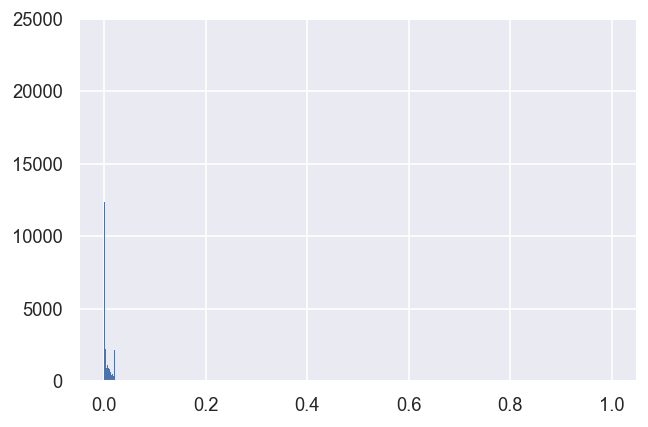

[0.5        0.5        1.         1.         0.33333333 1.
 0.33333333 1.         1.         0.33333333 0.5        0.5
 1.         0.5        0.5        0.33333333 1.        ]
0.7260044425392619
0.0017905920567046973


In [47]:
bins = np.arange(0,1, 0.001)
plt.hist(normalized_levenshtein_distances, bins = bins, edgecolor='none')
plt.ylim(0, 25000)
plt.show()

np_norm_ld = np.array(normalized_levenshtein_distances)
print(np_norm_ld[np_norm_ld > 0.3])# / len(np_norm_ld))
print(len(np_norm_ld[np_norm_ld < 0.001]) / len(np_norm_ld))

# for i, ld in enumerate(normalized_levenshtein_distances):
#     if ld > 0.3 and ld < 0.33 and i > 697:
#         print(i)
#         print(decode_string(decoded_pairs[i][0]))
#         print('-----------------------')
#         print(decode_string(decoded_pairs[i][1]))
#         break
        

print(np.mean(normalized_levenshtein_distances))
# print(np.argmax(normalized_levenshtein_distances))
# print(levenshtein_distances[647])
# print(decoded_pairs[647][0])
# print('-----------------------------')
# print(decoded_pairs[647][1])

# lvd_np = np.array(levenshtein_distances)
# print(len(lvd_np[lvd_np > 1000]) / len(lvd_np))
# jcd_np = np.array(jaccard_similarities)
# print(len(jcd_np[jcd_np < 0.4]) / len(jcd_np))
# print(jaccard_similarities[np.argmax(lvd_np)])
# print(decoded_pairs[np.argmax(lvd_np)][0])
# print('-------------------------------------------------')
# print(decoded_pairs[np.argmax(lvd_np)][1])

# print(f'Levenshtein distance: {np.mean(levenshtein_distances):5.2f}')
# print(f'Jaccard similarity: {np.mean(jaccard_similarities):8.2f}')



In [35]:
THRESHOLD = 0.3
LENGTH_THRESHOLD = 5000

new_indices = []
for i, nm_ld in enumerate(normalized_levenshtein_distances):
    if nm_ld > THRESHOLD:
        continue
        
    if len(decoded_pairs[i][0]) > LENGTH_THRESHOLD or len(decoded_pairs[i][1]) > LENGTH_THRESHOLD:
        continue
        
    new_indices.append(i)

In [36]:
train_pickle_path = os.path.join('..', 'data', 'post-ocr-correction', 'pickles', 'train_pairs.pickle')
eval_pickle_path = os.path.join('..', 'data', 'post-ocr-correction', 'pickles', 'eval_pairs.pickle')

In [37]:
decoded_ocr_lengths = [len(x[0]) for x in decoded_pairs]
decoded_gs_lengths = [len(x[1]) for x in decoded_pairs]

np_ocr_lengths = np.array(decoded_ocr_lengths)
np_gs_lengths = np.array(decoded_gs_lengths)
print(len(np_ocr_lengths[np_ocr_lengths > 5000]) / len(np_ocr_lengths))
print(len(np_gs_lengths[np_gs_lengths > 5000]) / len(np_gs_lengths))

# plt.scatter(decoded_ocr_lengths, decoded_gs_lengths, s=.5)
# ident = [0.0, max(max(decoded_ocr_lengths), max(decoded_gs_lengths))]
# plt.plot(ident,ident, c='r', linewidth=1, linestyle='--')
# plt.show()

0.0
0.0


In [40]:
print(decoded_pairs[new_indices[1050]][0])
print('---------------------------')
print(decoded_pairs[new_indices[1050]][1])

gland Beware of a Great MISHAP.-x 744 renncfs in o
---------------------------
gland Beware of a Great MISHAP. ##################
